In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_grid = pd.read_excel('./grid.xlsx', index_col=0)
df_grid = df_grid[df_grid.susceptance != 0] # leave out zero length network elements
df_grid['susceptance'] = df_grid['susceptance'].astype(float) / 10e6

df_substations = pd.read_excel('./substations.xlsx', index_col=0)
df_powerplants = pd.read_excel('./power_plants.xlsx', index_col=0)

Grid = nx.from_pandas_edgelist(df_grid, 'substation_1', 'substation_2', edge_attr=["susceptance"])

In [3]:
# Constructing PTDF

x_pu = nx.get_edge_attributes(Grid, 'susceptance').values()
b = [1 / x for x in x_pu]
B = np.diag(b)

K = nx.incidence_matrix(Grid, oriented=True).todense()

H = B.dot(K.T)
L = K.dot(H)
L_inv = np.linalg.pinv(L)

PTDF = H.dot(L_inv)

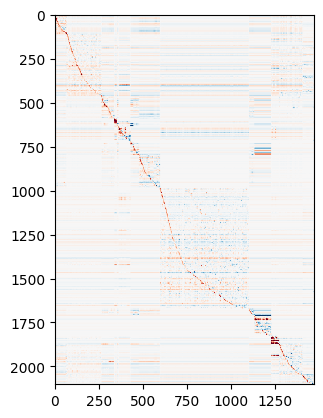

In [7]:
plt.imshow(PTDF, cmap="RdBu", vmin=-0.1, vmax=0.1)

In [8]:
PTDF

array([[-3.56803010e-01,  1.94318005e-01, -5.85515162e-02, ...,
         6.32614241e-02,  8.38008096e-03,  3.39981514e-03],
       [-1.95290932e-01, -1.33826975e-02,  2.74047892e-01, ...,
        -9.11039963e-03,  1.27348079e-02,  1.26692109e-02],
       [-1.05211469e-01, -5.64178855e-02, -5.06579326e-02, ...,
        -2.72003291e-02, -1.72222207e-03,  2.53604503e-04],
       ...,
       [-6.78886627e-04, -6.78886627e-04, -6.78886627e-04, ...,
        -6.78886627e-04, -6.78886627e-04, -6.78886627e-04],
       [-6.78886626e-04, -6.78886626e-04, -6.78886626e-04, ...,
        -6.78886626e-04, -6.78886626e-04, -6.78886626e-04],
       [-6.78886625e-04, -6.78886625e-04, -6.78886625e-04, ...,
        -6.78886625e-04, -6.78886625e-04, -6.78886625e-04]])